# HANDWRITTEN ARITHMETIC EXPRESSION RECOGNITION
## NAME: Shalini Ananthavel Jayalakshmi
## UBID: 50560497
## UBIT: ananthav

## 1. Data Preprocessing

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


def preprocessSymbolDataset(path, imgSize=(28, 28)):
    for className in os.listdir(path):
        classPath = os.path.join(path, className)
        if os.path.isdir(classPath):
            for imgName in os.listdir(classPath):
                imgPath = os.path.join(classPath, imgName)
                if imgName.startswith("exp"):
                    os.remove(imgPath)
                    continue
                image = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)  
                if image is None:
                    continue 
                cv2.imwrite(imgPath, image)


def loadSymbolData(path, imgSize=32):
    labelMap = {name: idx for idx, name in enumerate(sorted([name for name in os.listdir(path) if not name.startswith('.')]))}
    imgs, lbls = [], []

    for className in os.listdir(path):
        classPath = os.path.join(path, className)
        if not os.path.isdir(classPath): continue
        for imgName in os.listdir(classPath):
            imgPath = os.path.join(classPath, imgName)
            img = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)
            if img is None: continue
            img = cv2.resize(img, (imgSize, imgSize))
            _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)
            imgs.append(img.astype('float32') / 255.0)
            lbls.append(labelMap[className])

    imgs = np.array(imgs).reshape(-1, imgSize, imgSize, 1)
    lbls = to_categorical(np.array(lbls), num_classes=len(labelMap))

    X_train, X_temp, y_train, y_temp = train_test_split(imgs, lbls, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    return (X_train, X_val, X_test, y_train, y_val, y_test), labelMap

## 2. CNN Models

In [16]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
                                     GlobalAveragePooling2D, Input, LSTM, Bidirectional, Reshape,
                                     BatchNormalization, Activation, Add)
from tensorflow.keras.applications import MobileNetV2

def buildCnn(ipShape, numClasses):
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=ipShape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(numClasses, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

def buildMobilenet(ipShape, numClasses):
    base = MobileNetV2(input_shape=ipShape, include_top=False, weights=None)
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(128, activation='relu')(x)
    out = Dense(numClasses, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def residualBlock(x, filters, downsample=False):
    shortcut = x
    stride = 2 if downsample else 1

    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if downsample or x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def buildResnet(ipShape, numClasses):
    inputs = Input(shape=ipShape)
    x = residualBlock(inputs, 32)
    x = residualBlock(x, 64, downsample=True)
    x = residualBlock(x, 128, downsample=True)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(numClasses, activation='softmax')(x)
    model = Model(inputs, out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


## 3. Model training and Evaluation

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def modelTrain(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size
    )

    return history, history.history['val_accuracy'][-1], history.history['val_loss'][-1]


def modelEvaluate(model, X_test, y_test, invLabelMap):
    predProbs = model.predict(X_test)
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")

    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)
    y_true = y_test.argmax(axis=1)

    print("\nClassification Report:")
    targetNames = list(invLabelMap.values())  
    print(classification_report(y_true, y_pred_classes, target_names=targetNames))
    
    return loss, acc

def saveModel(model, path):
    model.save(path)

def loadData(path):
    import numpy as np
    data = np.load(path)
    return data["X_train"], data["y_train"], data["X_val"], data["y_val"], data["X_test"], data["y_test"]


## 4. Loading and preprocessing Symbol dataset

In [7]:
SYMBOLS_PATH = "../../Downloads/data"
EQUATION_IMG_DIR = "../../Downloads/archive-2/Handwritten_equations_images"
EQUATION_LABEL_PATH = "../../Downloads/archive-2/Maths_eqations_handwritten.xlsx"
MODEL_SAVE_DIR = "./saved_models"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
IMG_SIZE = 32
EPOCHS = 10

preprocessSymbolDataset(SYMBOLS_PATH)

(X_train, X_val, X_test, y_train, y_val, y_test), symbolLblMap = loadSymbolData(SYMBOLS_PATH, IMG_SIZE)
ipShape = X_train.shape[1:]
numClasses = len(symbolLblMap)


invLabelMap = {v: k for k, v in symbolLblMap.items()} 
print("Symbol map -> ",symbolLblMap)
print("Inverse map -> ",invLabelMap)

Symbol map ->  {'(': 0, ')': 1, '+': 2, '-': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, ':': 14, '=': 15, 'x': 16}
Inverse map ->  {0: '(', 1: ')', 2: '+', 3: '-', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: ':', 15: '=', 16: 'x'}


## 5. CNN Training, Validation and Test

In [ ]:
cnn = buildCnn(ipShape, numClasses)
print("\nTraining CNN...")
historyCnn, accCnn, lossCnn = modelTrain(cnn, X_train, y_train, X_val, y_val, EPOCHS)
print("CNN Evaluation:")
testLossCnn, testAccCnn = modelEvaluate(cnn, X_test, y_test, invLabelMap)
saveModel(cnn, os.path.join(MODEL_SAVE_DIR, "cnn_model.h5"))


Training CNN...
Epoch 1/10


/Applications/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1410/1410 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.7970 - loss: 0.7267 - val_accuracy: 0.9415 - val_loss: 0.1993
Epoch 2/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.9363 - loss: 0.2157 - val_accuracy: 0.9555 - val_loss: 0.1539
Epoch 3/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.9503 - loss: 0.1624 - val_accuracy: 0.9576 - val_loss: 0.1421
Epoch 4/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - accuracy: 0.9608 - loss: 0.1345 - val_accuracy: 0.9626 - val_loss: 0.1389
Epoch 5/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.9647 - loss: 0.1189 - val_accuracy: 0.9642 - val_loss: 0.1300
Epoch 6/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.9699 - loss: 0.0979 - val_accuracy: 0.9654 - val_loss: 0.1338
Epoch 7/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.9738 - loss: 0.0853 - val_accuracy: 0.9656 - val_loss: 0.1278
Epoch 8/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.9748 - loss: 0.07


Classification Report:
              precision    recall  f1-score   support

           (       0.92      0.95      0.94       679
           )       0.97      0.98      0.97       720
           +       0.97      0.97      0.97      1232
           -       0.99      0.99      0.99      1713
           0       0.97      0.97      0.97       339
           1       0.94      0.93      0.94      1247
           2       0.98      0.98      0.98      1284
           3       0.98      0.95      0.97       514
           4       0.99      0.93      0.96       378
           5       0.96      0.89      0.92       174
           6       0.96      0.97      0.96       153
           7       0.96      0.93      0.95       132
           8       0.97      0.96      0.96       147
           9       0.93      0.95      0.94       158
           :       0.93      0.76      0.83        33
           =       0.96      0.98      0.97       633
           x       0.98      1.00      0.99       128

  

## 6. Mobilenet Training, Validation and Test

In [10]:
mobilenet = buildMobilenet(ipShape, numClasses)
print("\nTraining MobileNet...")
historyMn, accMn, lossMn = modelTrain(mobilenet, X_train, y_train, X_val, y_val, EPOCHS)
print("MobileNet Evaluation:")
testLossMn, testAccMn = modelEvaluate(mobilenet, X_test, y_test, invLabelMap)
saveModel(mobilenet, os.path.join(MODEL_SAVE_DIR, "mobilenet_model.h5"))


Training MobileNet...
Epoch 1/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 130s 84ms/step - accuracy: 0.6232 - loss: 1.2636 - val_accuracy: 0.1354 - val_loss: 2.6294
Epoch 2/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 121s 86ms/step - accuracy: 0.8959 - loss: 0.3782 - val_accuracy: 0.1355 - val_loss: 2.6139
Epoch 3/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 117s 83ms/step - accuracy: 0.9251 - loss: 0.2830 - val_accuracy: 0.2109 - val_loss: 2.4627
Epoch 4/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 122s 86ms/step - accuracy: 0.9372 - loss: 0.2343 - val_accuracy: 0.9190 - val_loss: 0.2994
Epoch 5/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 122s 87ms/step - accuracy: 0.9433 - loss: 0.2135 - val_accuracy: 0.9326 - val_loss: 0.5042
Epoch 6/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 122s 87ms/step - accuracy: 0.9510 - loss: 0.1838 - val_accuracy: 0.9319 - val_loss: 0.4892
Epoch 7/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 118s 84ms/step - accuracy: 0.9472 - loss: 0.1962 - val_accuracy: 0.9334 - val_loss: 0.4992
Epoch 8/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 119s


Classification Report:
              precision    recall  f1-score   support

           (       0.92      0.97      0.94       679
           )       0.97      0.98      0.98       720
           +       0.98      0.97      0.98      1232
           -       0.99      0.99      0.99      1713
           0       0.84      0.99      0.91       339
           1       0.95      0.93      0.94      1247
           2       0.93      1.00      0.96      1284
           3       1.00      0.93      0.96       514
           4       0.98      0.95      0.97       378
           5       0.93      0.96      0.95       174
           6       0.95      0.97      0.96       153
           7       0.96      0.81      0.88       132
           8       0.93      0.95      0.94       147
           9       0.84      0.96      0.90       158
           :       0.95      0.58      0.72        33
           =       0.99      0.82      0.90       633
           x       0.98      0.96      0.97       128

  

## 7. ResNet Training, Validation and Test

In [17]:
resnet = buildResnet(ipShape, numClasses)
print("\nTraining ResNet...")
historyRn, accRn, lossRn = modelTrain(resnet, X_train, y_train, X_val, y_val, EPOCHS)
print("ResNet Evaluation:")
testLossRn, testAccRn = modelEvaluate(resnet, X_test, y_test, invLabelMap)
saveModel(resnet, os.path.join(MODEL_SAVE_DIR, "resnet_model.h5"))


Training ResNet...
Epoch 1/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 229s 160ms/step - accuracy: 0.7916 - loss: 0.7451 - val_accuracy: 0.6553 - val_loss: 1.3777
Epoch 2/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 211s 150ms/step - accuracy: 0.9357 - loss: 0.2191 - val_accuracy: 0.9619 - val_loss: 0.1416
Epoch 3/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 215s 153ms/step - accuracy: 0.9532 - loss: 0.1637 - val_accuracy: 0.3594 - val_loss: 3.9883
Epoch 4/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 210s 149ms/step - accuracy: 0.9605 - loss: 0.1364 - val_accuracy: 0.6801 - val_loss: 1.9548
Epoch 5/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 218s 155ms/step - accuracy: 0.9661 - loss: 0.1164 - val_accuracy: 0.6606 - val_loss: 1.7126
Epoch 6/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 220s 156ms/step - accuracy: 0.9722 - loss: 0.0960 - val_accuracy: 0.7882 - val_loss: 0.9554
Epoch 7/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 210s 149ms/step - accuracy: 0.9751 - loss: 0.0839 - val_accuracy: 0.9761 - val_loss: 0.1012
Epoch 8/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 

              precision    recall  f1-score   support

           (       0.93      0.96      0.95       679
           )       0.97      0.98      0.98       720
           +       0.98      0.98      0.98      1232
           -       0.99      1.00      0.99      1713
           0       0.99      0.98      0.99       339
           1       0.96      0.93      0.94      1247
           2       0.98      0.99      0.99      1284
           3       1.00      0.96      0.98       514
           4       0.98      0.97      0.97       378
           5       0.98      0.96      0.97       174
           6       0.97      0.99      0.98       153
           7       0.97      0.97      0.97       132
           8       0.94      0.98      0.96       147
           9       0.93      0.98      0.95       158
           :       0.90      0.82      0.86        33
           =       0.98      0.97      0.98       633
           x       0.97      0.98      0.98       128

    accuracy              

## 8. Analysis

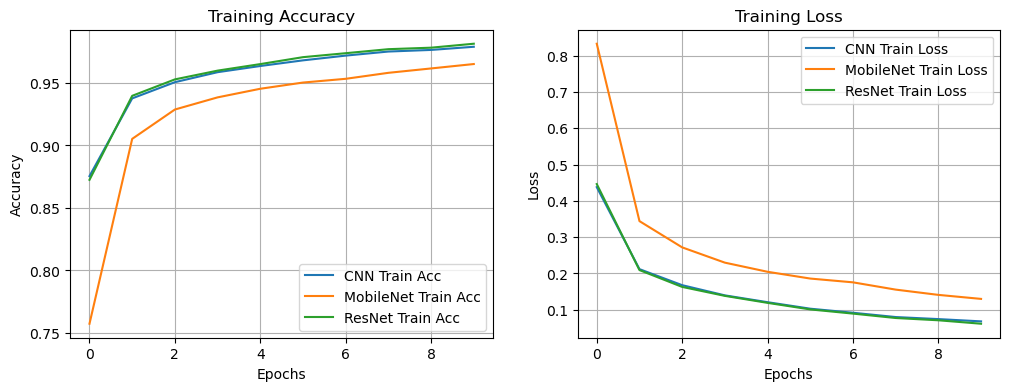

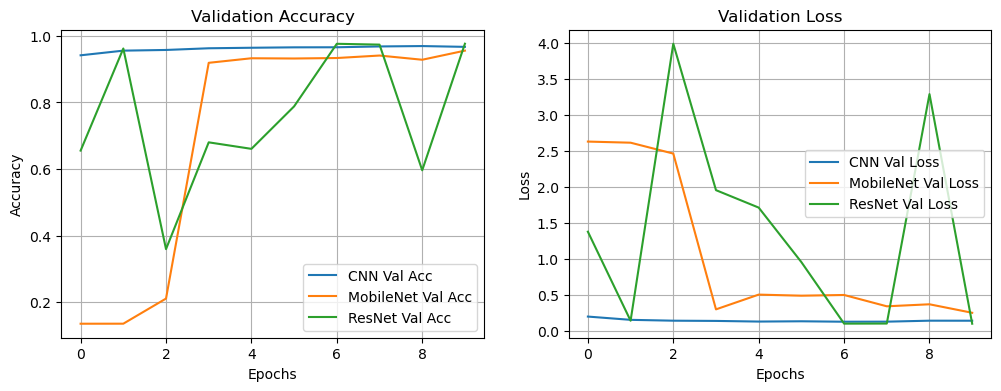

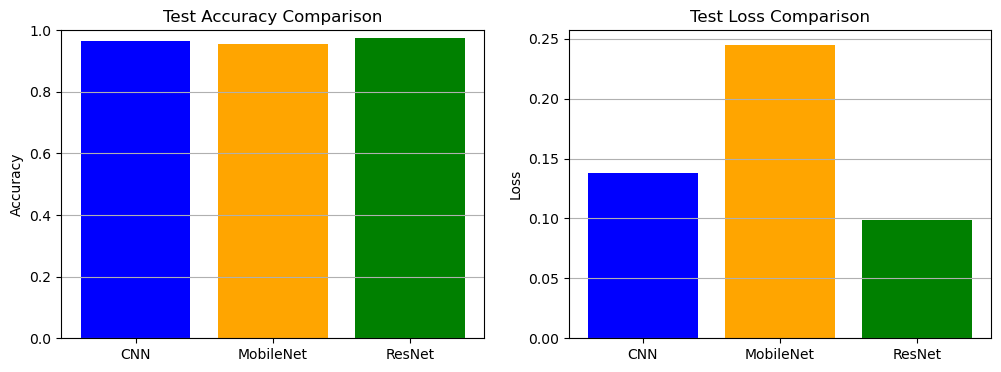

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(historyCnn.history['accuracy'], label='CNN Train Acc')
plt.plot(historyMn.history['accuracy'], label='MobileNet Train Acc')
plt.plot(historyRn.history['accuracy'], label='ResNet Train Acc')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(historyCnn.history['loss'], label='CNN Train Loss')
plt.plot(historyMn.history['loss'], label='MobileNet Train Loss')
plt.plot(historyRn.history['loss'], label='ResNet Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(historyCnn.history['val_accuracy'], label='CNN Val Acc')
plt.plot(historyMn.history['val_accuracy'], label='MobileNet Val Acc')
plt.plot(historyRn.history['val_accuracy'], label='ResNet Val Acc')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(historyCnn.history['val_loss'], label='CNN Val Loss')
plt.plot(historyMn.history['val_loss'], label='MobileNet Val Loss')
plt.plot(historyRn.history['val_loss'], label='ResNet Val Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(['CNN', 'MobileNet', 'ResNet'],
        [testAccCnn, testAccMn, testAccRn],
        color=['blue', 'orange', 'green'])
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y')

plt.subplot(1, 2, 2)
plt.bar(['CNN', 'MobileNet', 'ResNet'],
        [testLossCnn, testLossMn, testLossRn],
        color=['blue', 'orange', 'green'])
plt.title('Test Loss Comparison')
plt.ylabel('Loss')
plt.grid(axis='y')
plt.show()


/var/folders/20/6yqsb4ws0cjg40r4mpkttk0c0000gn/T/ipykernel_23017/4207846700.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


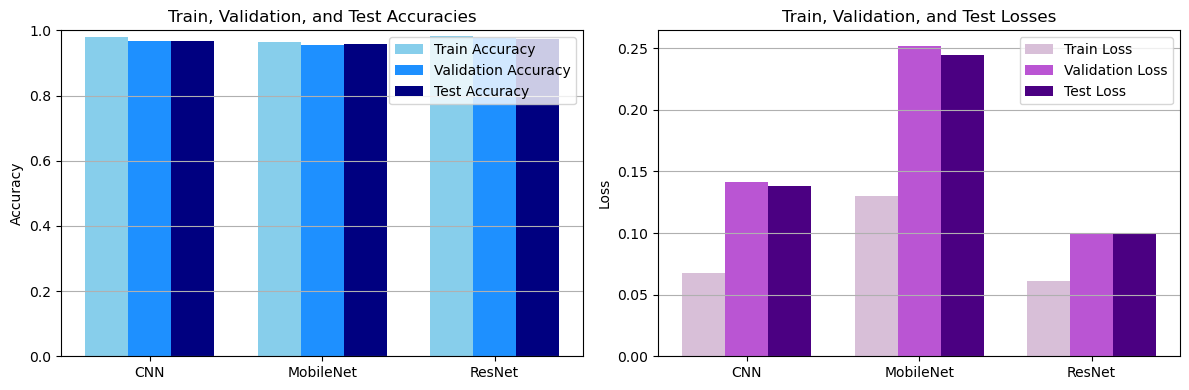

In [23]:
import matplotlib.pyplot as plt
import numpy as np

trainAccs = [historyCnn.history['accuracy'][9], historyMn.history['accuracy'][9], historyRn.history['accuracy'][9]]
valAccs = [accCnn, accMn, accRn]
testAccs = [testAccCnn, testAccMn, testAccRn]

trainLosses = [historyCnn.history['loss'][9], historyMn.history['loss'][9], historyRn.history['loss'][9]]
valLosses = [lossCnn, lossMn, lossRn]
testLosses = [testLossCnn, testLossMn, testLossRn]

models = ['CNN', 'MobileNet', 'ResNet']
x = np.arange(len(models))  
width = 0.25  

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.bar(x - width, trainAccs, width, label='Train Accuracy', color='skyblue')
plt.bar(x, valAccs, width, label='Validation Accuracy', color='dodgerblue')
plt.bar(x + width, testAccs, width, label='Test Accuracy', color='navy')
plt.ylabel('Accuracy')
plt.title('Train, Validation, and Test Accuracies')
plt.xticks(x, models)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
           
plt.subplot(1,2,2)
plt.bar(x - width, trainLosses, width, label='Train Loss', color='thistle')
plt.bar(x, valLosses, width, label='Validation Loss', color='mediumorchid')
plt.bar(x + width, testLosses, width, label='Test Loss', color='indigo')
plt.ylabel('Loss')
plt.title('Train, Validation, and Test Losses')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [24]:
print("\nModel Comparison")
print(f"{'Model':<10}{'Val Acc':>10}{'Val Loss':>10}{'Test Acc':>12}{'Test Loss':>12}")
print("-------------------------------------------------------------")
print(f"{'CNN':<10}{accCnn:>10.4f}{lossCnn:>10.4f}{testAccCnn:>12.4f}{testLossCnn:>12.4f}")
print(f"{'MobileNet':<10}{accMn:>10.4f}{lossMn:>10.4f}{testAccMn:>12.4f}{testLossMn:>12.4f}")
print(f"{'ResNet':<10}{accRn:>10.4f}{lossRn:>10.4f}{testAccRn:>12.4f}{testLossRn:>12.4f}")


Model Comparison
Model        Val Acc  Val Loss    Test Acc   Test Loss
-------------------------------------------------------------
CNN           0.9669    0.1417      0.9657      0.1383
MobileNet     0.9555    0.2519      0.9566      0.2448
ResNet        0.9763    0.1000      0.9742      0.0991


## 9. Sequence Recognition

In [26]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

resnetModel = load_model("./saved_models/resnet_model.h5")


def visualizeDetectedSymbols(org, boxes):
    debugImg = org.copy()
    for (x, y, w, h, _) in boxes:
        cv2.rectangle(debugImg, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.figure(figsize=(8, 2))
    plt.imshow(cv2.cvtColor(debugImg, cv2.COLOR_BGR2RGB))
    plt.title("Detected Symbols")
    plt.axis("off")
    plt.show()


def padResizeSymbol(symbol, size=32):
    hSym, wSym = symbol.shape
    padding = abs(hSym - wSym) // 2
    if hSym > wSym:
        symbol = cv2.copyMakeBorder(symbol, 0, 0, padding, padding, cv2.BORDER_CONSTANT, value=0)
    else:
        symbol = cv2.copyMakeBorder(symbol, padding, padding, 0, 0, cv2.BORDER_CONSTANT, value=0)
    symbol = cv2.resize(symbol, (size, size))
    symbol = symbol.astype('float32') / 255.0
    symbol = np.expand_dims(symbol, axis=-1)
    return symbol


def extractContours(thresh):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 100))
    dilated = cv2.dilate(thresh, kernel, iterations=1)
    contours, _ = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours


def preprocessExprImage(imgPath, debug=False):
    org = cv2.imread(imgPath)
    gray = cv2.cvtColor(org, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours = extractContours(thresh)

    boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 5 and h > 10:
            symbol = thresh[y:y+h, x:x+w]
            symbol = padResizeSymbol(symbol)
            boxes.append((x, y, w, h, symbol))

    boxes.sort(key=lambda tup: tup[0])
    sortSymbols = [sym for (_, _, _, _, sym) in boxes]

    if debug:
        visualizeDetectedSymbols(org, boxes)

    return np.array(sortSymbols).reshape(-1, 32, 32, 1)

In [27]:
def predictExpr(symbolImgs):
    if symbolImgs.size == 0:
        print("No symbol images found.")
        return ""
    
    predictions = resnetModel.predict(symbolImgs)
    expr = ""
    for probs in predictions:
        topIdx = np.argmax(probs)
        predictedChar = invLabelMap[topIdx]
        expr += predictedChar
    return expr


def evaluateExpr(expr):
    expr = expr.replace('x', '*').replace(':', '/')
    if '=' not in expr:
        expr += '='
    expr = expr.split('=')[0] 
    try:
        return eval(expr)
    except Exception:
        return "Invalid"


Processing Image 1...


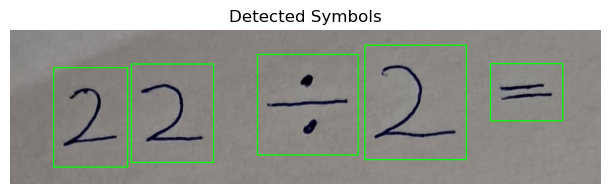

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image 1: 22:2= 11.0

Processing Image 2...


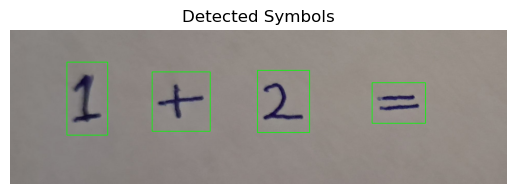

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Image 2: 1+2= 3

Processing Image 3...


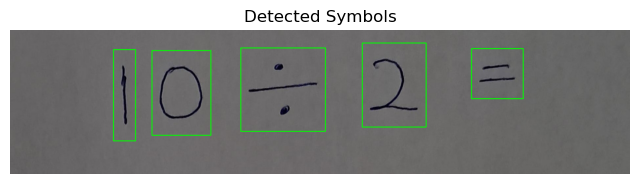

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Image 3: 10:2= 5.0

Processing Image 4...


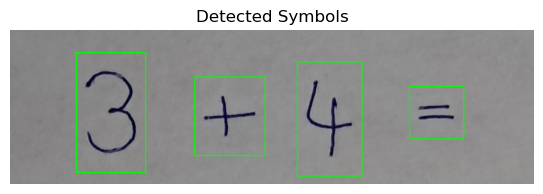

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Image 4: 3+4= 7

Processing Image 5...


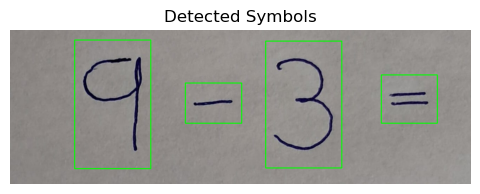

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image 5: 9-3= 6

Processing Image 6...


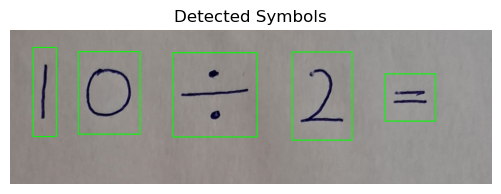

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Image 6: 10:2= 5.0

Processing Image 7...


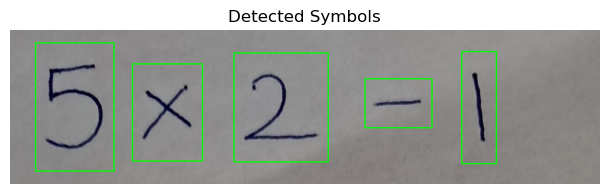

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image 7: 5x2-1 = 9

Processing Image 8...


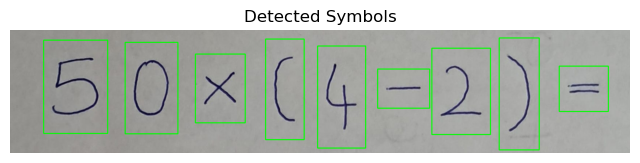

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image 8: 50x(4-2)= 100

Processing Image 9...


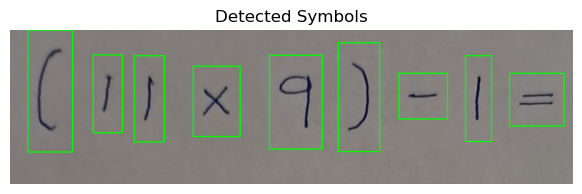

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image 9: (11x4)-1= 43

Processing Image 10...


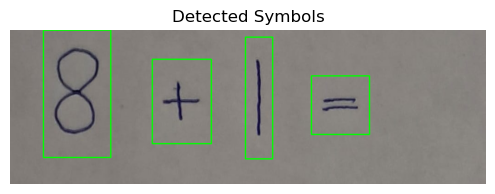

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image 10: 8+1= 9

Processing Image 11...


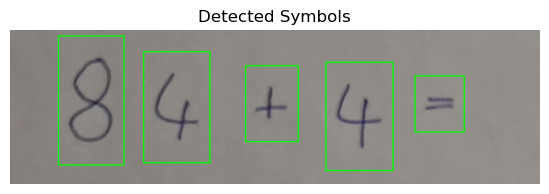

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image 11: 84+4= 88

Processing Image 12...


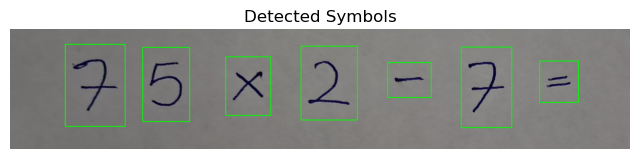

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image 12: 75x2-7= 143

Processing Image 13...


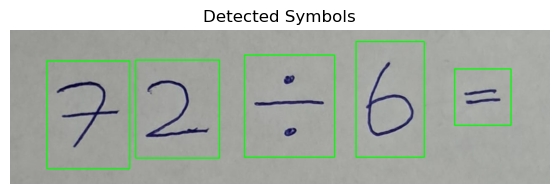

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Image 13: 72:6= 12.0

Processing Image 14...


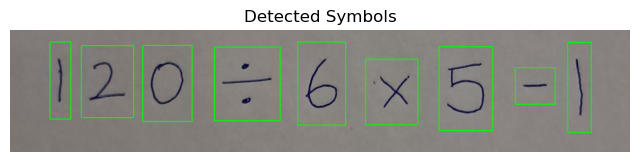

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image 14: 120:6x5-1 = 99.0

Processing Image 15...


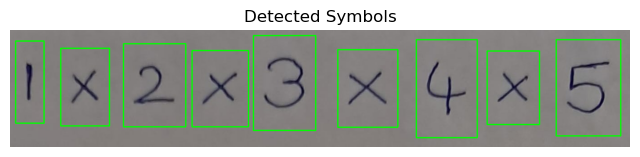

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image 15: 1x2x0x4x5 = 0


In [ ]:
exprImgDir = "./seq_data/images"
imgFiles = sorted([f for f in os.listdir(exprImgDir) if f.lower().endswith('.jpeg')])
numImgs = len(imgFiles)

for i in range(1, numImgs + 1):
    print(f"\nProcessing Image {i}...")
    imgPath = os.path.join(exprImgDir, f"{i}.jpeg")
    symbols = preprocessExprImage(imgPath, debug=True)
    if symbols.size == 0:
        print("No symbols found. Skipping.")
        continue
    expr = predictExpr(symbols)
    result = evaluateExpr(expr)
    if '=' not in expr:
        print(f"Image {i}: {expr} = {result}")
    else:
        print(f"Image {i}: {expr} {result}")

In [ ]:
import pandas as pd

df = pd.read_excel("./seq_data/Results_validation.xlsx")  
exprCorr = 0
ansCorr = 0
total = len(df)

for index, row in df.iterrows():
    imgName = row['Img_name']
    trueExpr = str(row['Expression']).replace(' ', '')
    trueAns = str(row['Answer']).strip()

    imgPath = os.path.join(exprImgDir, f"{imgName}.jpeg")
    print(imgPath)
    symbols = preprocessExprImage(imgPath, debug=False)
    
    if symbols.size == 0:
        continue
    
    predExpr = predictExpr(symbols)
    predAns = evaluateExpr(predExpr)

    predExprClean = predExpr.replace(' ', '')
    
    if predExprClean == trueExpr:
        exprCorr += 1

    if str(predAns).strip() == trueAns:
        ansCorr += 1

# Compute accuracies
exprAcc = exprCorr / total * 100
ansAcc = ansCorr / total * 100

print(f"\nExpression Accuracy: {exprAcc:.2f}%")
print(f"Answer Accuracy: {ansAcc:.2f}%")

../../Downloads/seq_data/images/1.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
../../Downloads/seq_data/images/2.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
../../Downloads/seq_data/images/3.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
../../Downloads/seq_data/images/4.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
../../Downloads/seq_data/images/5.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
../../Downloads/seq_data/images/6.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
../../Downloads/seq_data/images/7.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
../../Downloads/seq_data/images/8.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
../../Downloads/seq_data/images/9.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
../../Downloads/seq_data/images/10.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
../../Downloads/seq_data/images/11.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
../../Downloads/seq_data/images/12.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
../../Downloads/seq_data/images/13.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/